<a href="https://colab.research.google.com/github/rohanchaudhary21/E-Commerce-Dashboard-Power-BI/blob/main/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pandas sqlalchemy matplotlib seaborn

In [3]:
from google.colab import files
import pandas as pd
import sqlite3

# 1. Upload CSVs (Select multiple files when prompted)
uploaded = files.upload()

# 2. Connect to SQLite (creates a temporary DB in Colab RAM)
conn = sqlite3.connect('ecommerce.db')

# 3. Loop through uploaded files and load them into the DB
for filename in uploaded.keys():
    table_name = filename.split('.')[0] # Use filename as table name
    df = pd.read_csv(filename)
    df.to_sql(table_name, conn, if_exists='replace', index=False)
    print(f"Loaded {filename} into table: {table_name}")

print("Database setup complete!")


Saving olist_sellers_dataset.csv to olist_sellers_dataset.csv
Saving product_category_name_translation.csv to product_category_name_translation.csv
Saving olist_products_dataset.csv to olist_products_dataset.csv
Saving olist_order_reviews_dataset.csv to olist_order_reviews_dataset.csv
Saving olist_orders_dataset.csv to olist_orders_dataset.csv
Saving olist_order_payments_dataset.csv to olist_order_payments_dataset.csv
Saving olist_order_items_dataset.csv to olist_order_items_dataset.csv
Saving olist_geolocation_dataset.csv to olist_geolocation_dataset.csv
Saving olist_customers_dataset.csv to olist_customers_dataset.csv
Loaded olist_sellers_dataset.csv into table: olist_sellers_dataset
Loaded product_category_name_translation.csv into table: product_category_name_translation
Loaded olist_products_dataset.csv into table: olist_products_dataset
Loaded olist_order_reviews_dataset.csv into table: olist_order_reviews_dataset
Loaded olist_orders_dataset.csv into table: olist_orders_dataset
L

In [5]:
sql_query = """
SELECT
    strftime('%Y-%m', o.order_purchase_timestamp) as month,
    COUNT(DISTINCT o.order_id) AS total_orders,
    SUM(oi.price) AS total_revenue,
    SUM(oi.price) / COUNT(DISTINCT o.order_id) AS avg_order_value
FROM olist_orders_dataset o
JOIN olist_order_items_dataset oi ON o.order_id = oi.order_id
WHERE o.order_status = 'delivered'
GROUP BY 1
ORDER BY 1;
"""

# Assuming 'conn' is your sqlite3 connection object from previous cells
monthly_kpis = pd.read_sql_query(sql_query, conn)
print(monthly_kpis)

      month  total_orders  total_revenue  avg_order_value
0   2016-09             1         134.97       134.970000
1   2016-10           265       40325.11       152.170226
2   2016-12             1          10.90        10.900000
3   2017-01           750      111798.36       149.064480
4   2017-02          1653      234223.40       141.695947
5   2017-03          2546      359198.85       141.083602
6   2017-04          2303      340669.68       147.924307
7   2017-05          3546      489338.25       137.997250
8   2017-06          3135      421923.37       134.584807
9   2017-07          3872      481604.52       124.381333
10  2017-08          4193      554699.70       132.291844
11  2017-09          4150      607399.67       146.361366
12  2017-10          4478      648247.65       144.762762
13  2017-11          7289      987765.37       135.514525
14  2017-12          5513      726033.19       131.694756
15  2018-01          7069      924645.00       130.802801
16  2018-02   

In [9]:
#Top 10 Categories by Revenue
sql_query = """
SELECT
    p.product_category_name,
    COUNT(oi.order_id) as items_sold,
    SUM(oi.price) AS total_revenue
FROM olist_order_items_dataset oi
JOIN olist_products_dataset p ON oi.product_id = p.product_id
GROUP BY p.product_category_name
ORDER BY total_revenue DESC
LIMIT 10;
"""

top_categories_revenue = pd.read_sql_query(sql_query, conn)
print(top_categories_revenue)

    product_category_name  items_sold  total_revenue
0            beleza_saude        9670     1258681.34
1      relogios_presentes        5991     1205005.68
2         cama_mesa_banho       11115     1036988.68
3           esporte_lazer        8641      988048.97
4  informatica_acessorios        7827      911954.32
5        moveis_decoracao        8334      729762.49
6              cool_stuff        3796      635290.85
7   utilidades_domesticas        6964      632248.66
8              automotivo        4235      592720.11
9      ferramentas_jardim        4347      485256.46


                          seller_id  total_revenue  total_items  rank
0  4869f7a5dfa277a7dca6462dcf3b52b2      229472.63         1156   1.0
1  53243585a1d6dc2643021fd1853d8905      222776.05          410   2.0
2  4a3ca9315b744ce9f8e9374361493884      200472.92         1987   3.0
3  fa1c13f2614d7b5c4749cbc52fecda94      194042.03          586   4.0
4  7c67e1448b00f6e969d365cea6b010ab      187923.89         1364   5.0


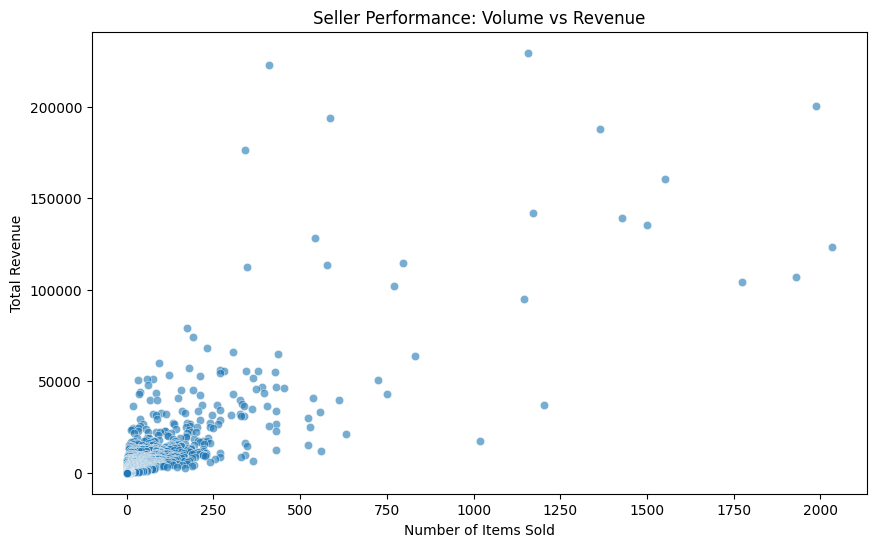

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data from SQL
query = """
SELECT oi.seller_id, SUM(oi.price) as total_revenue, COUNT(oi.order_id) as total_items
FROM olist_order_items_dataset oi
GROUP BY oi.seller_id
ORDER BY total_revenue DESC
"""
sellers = pd.read_sql(query, conn)

# 1. Rank Sellers
sellers['rank'] = sellers['total_revenue'].rank(ascending=False)
print(sellers.head(5))

# 2. Pricing Impact Visualization (Revenue vs Volume)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sellers, x='total_items', y='total_revenue', alpha=0.6)
plt.title('Seller Performance: Volume vs Revenue')
plt.xlabel('Number of Items Sold')
plt.ylabel('Total Revenue')
plt.show()


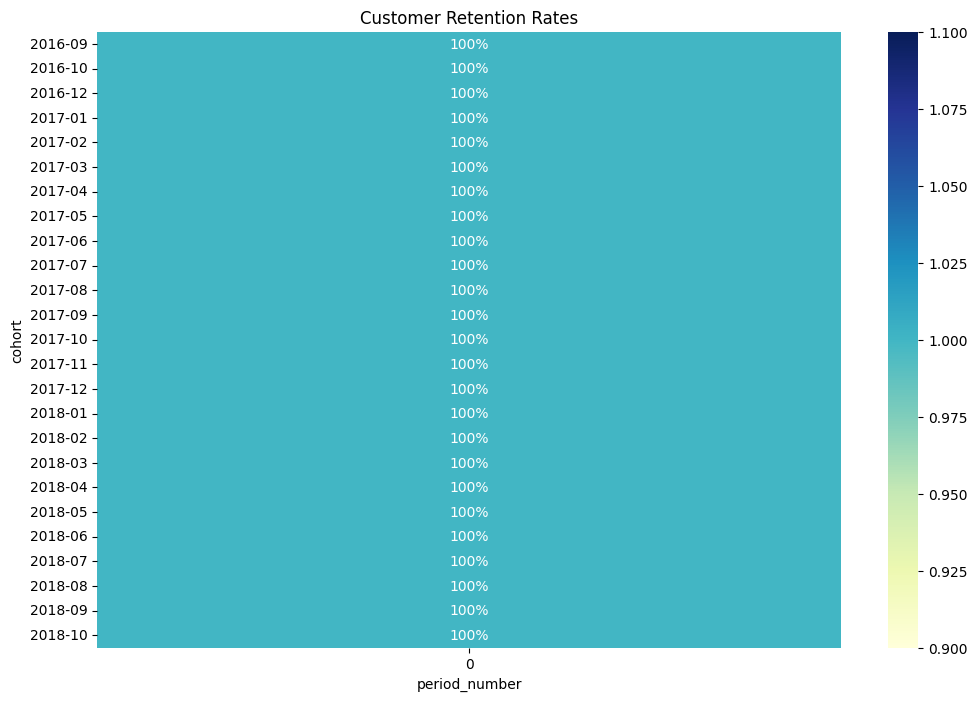

In [11]:
# Load orders
df_orders = pd.read_sql("SELECT customer_id, order_purchase_timestamp FROM olist_orders_dataset", conn)
df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp'])

# Create Cohort Month (Month of user's first purchase)
# Note: In Olist, customer_id changes per order. You need customer_unique_id from the customers table
# for true retention. Assuming joined data or simplified customer_id for this example:

df_orders['order_month'] = df_orders['order_purchase_timestamp'].dt.to_period('M')
df_orders['cohort'] = df_orders.groupby('customer_id')['order_purchase_timestamp'] \
                               .transform('min').dt.to_period('M')

# Calculate Cohort Index (Months since first purchase)
from operator import attrgetter
df_cohort = df_orders.groupby(['cohort', 'order_month']).agg(n_customers=('customer_id', 'nunique')).reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

# Pivot for Heatmap
cohort_pivot = df_cohort.pivot_table(index='cohort', columns='period_number', values='n_customers')
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

# Plot Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(retention_matrix, annot=True, fmt='.0%', cmap='YlGnBu')
plt.title('Customer Retention Rates')
plt.show()
